In [1]:
import os 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import torch
import numpy as np
import pickle
from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from torch_geometric.data import Data

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Hydra 초기화 및 구성 로드
initialize(config_path="config", version_base="1.1")
cfg = compose(config_name="config.yaml")

# 구성 확인
print(OmegaConf.to_yaml(cfg))

experiment:
  input_features:
    coords: true
dataset:
  max_epochs: 3000
arch:
  encoder:
    n_enc_layers: 1
  processor:
    hidden_dim: 128
    output_dim: 1
    n_blocks: 1
    n_gnn_layers: 1
  decoder:
    n_dec_layers: 1
scheduler:
  initial_lr: 0.0005
  weight_decay: 0.05
path:
  data_dir: /data/SimJEB/



In [3]:
from train import Trainer

# 시드 고정
set_seed(36)

# Trainer 인스턴스 생성 및 학습 시작
trainer = Trainer(cfg, shuffle=False)

filename = 'outputs/2025-01-09/13-25-09/ckpt/test/best_val_loss.pt'

ckpt = torch.load(filename)
trainer.model.load_state_dict(ckpt)

save point = /home/ubuntu/JHL/SimJEB/1_MP/3_experiment_group_specific_yinp/ckpt/test
[train] 21 torch.Size([36544, 3]) torch.Size([36544, 3]) torch.Size([36544, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 30 torch.Size([21906, 3]) torch.Size([21906, 3]) torch.Size([21906, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 38 torch.Size([58270, 3]) torch.Size([58270, 3]) torch.Size([58270, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 62 torch.Size([28832, 3]) torch.Size([28832, 3]) torch.Size([28832, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 8 torch.Size([60068, 3]) torch.Size([60068, 3]) torch.Size([60068, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 9 torch.Size([97030, 3]) torch.Size([97030, 3]) torch.Size([97030, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 15 torch.Size([46732, 3]) torch.Size([46732, 3]) torch.Size([46732, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 23 torch.Size([43350, 3]) torch.Size([43350, 3]) torch.Size([43350, 3]) tensor([0.5152, 0.5152, 1.0000])
[train] 6 tor

<All keys matched successfully>

(57168, 1)
(57168, 1)


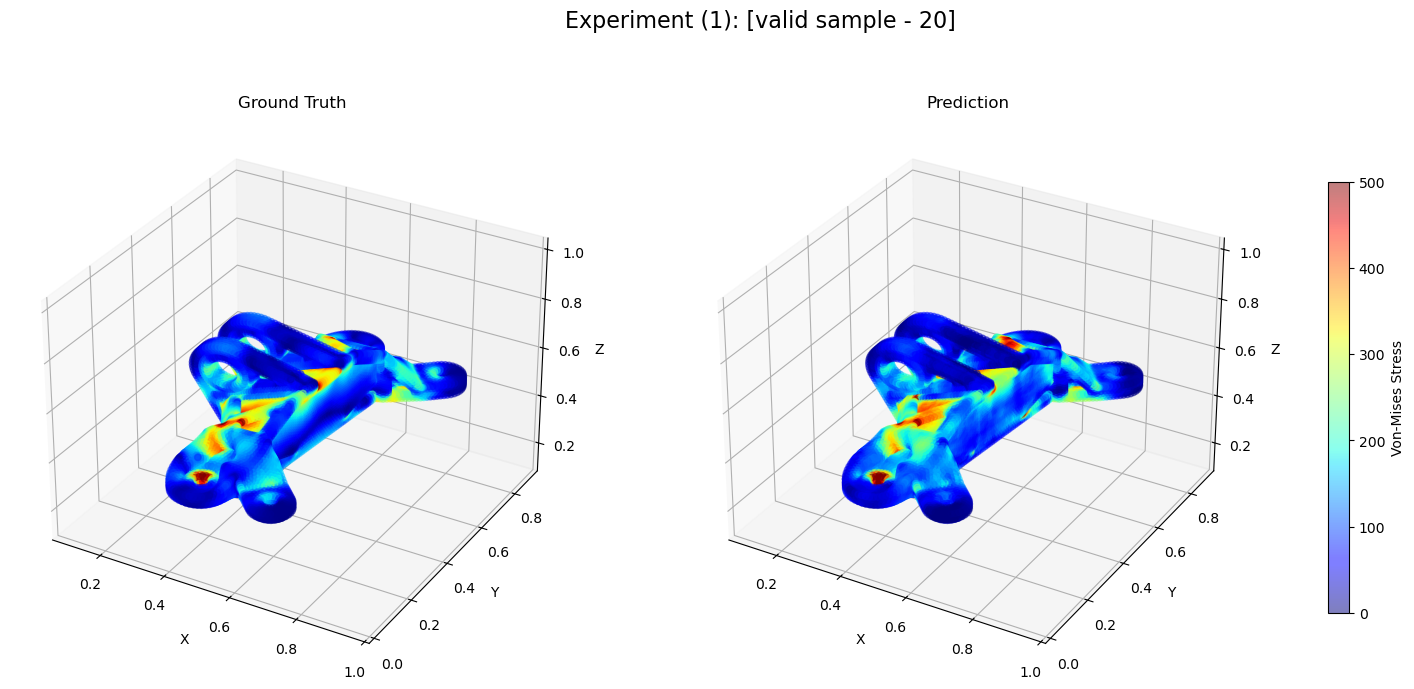

(87908, 1)
(87908, 1)


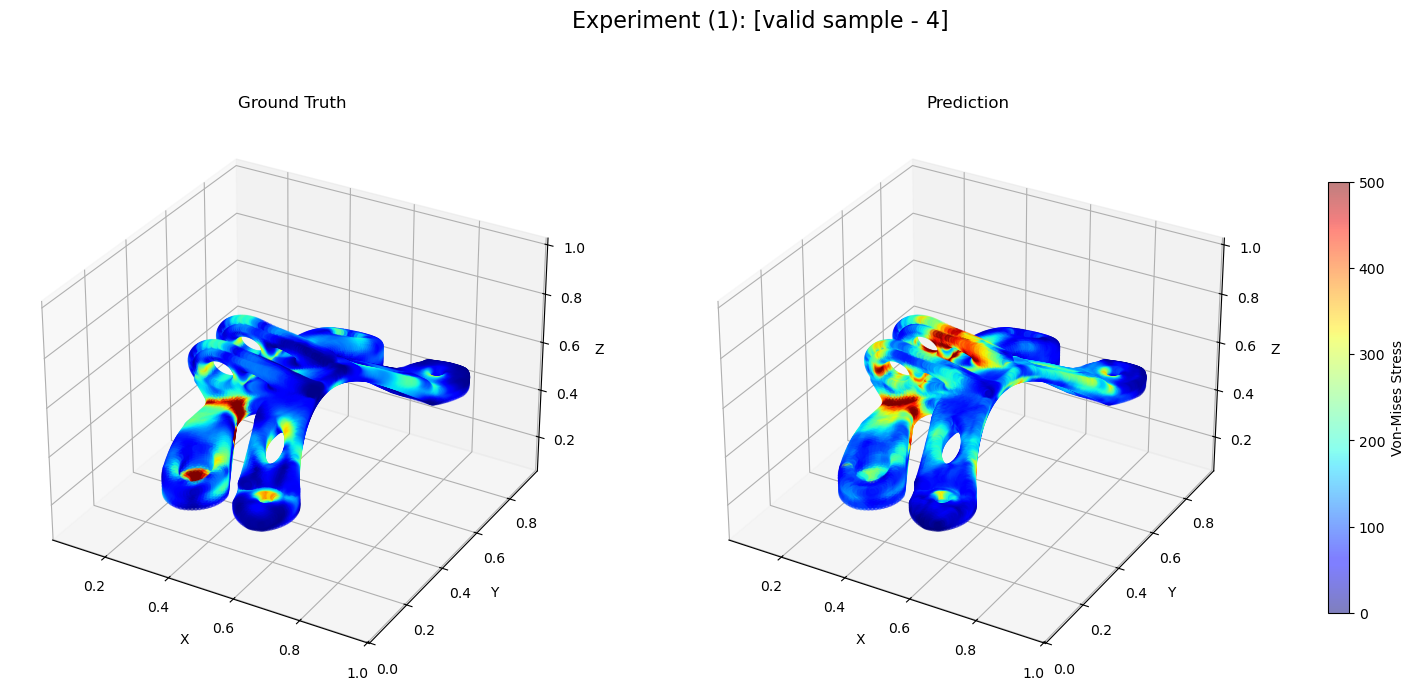

(112873, 1)
(112873, 1)


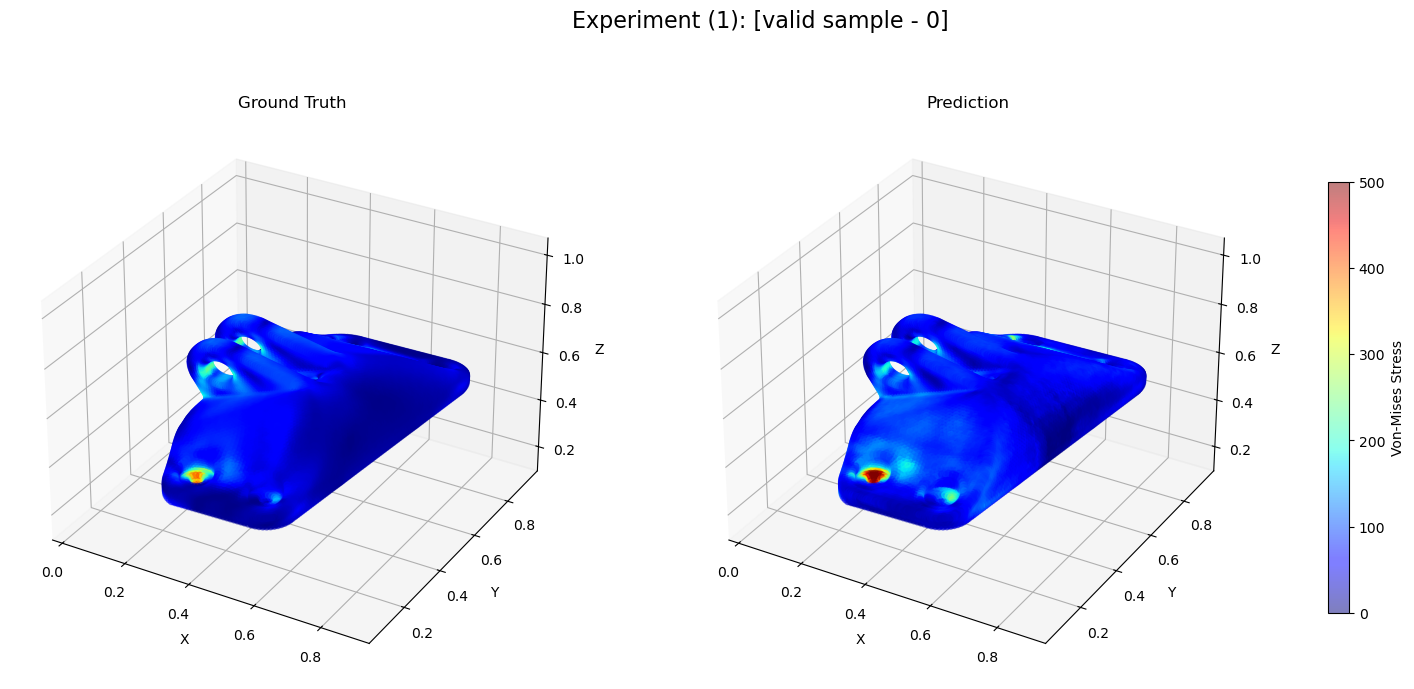

(123939, 1)
(123939, 1)


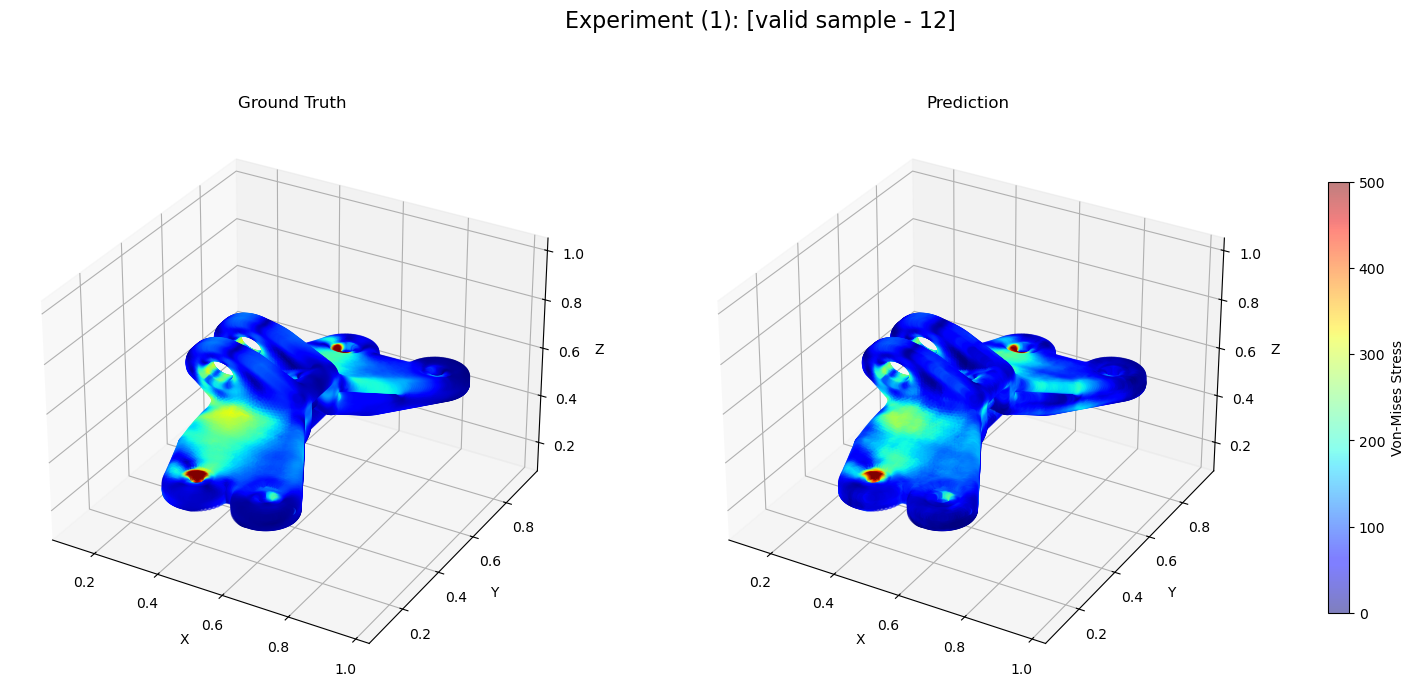

(62273, 1)
(62273, 1)


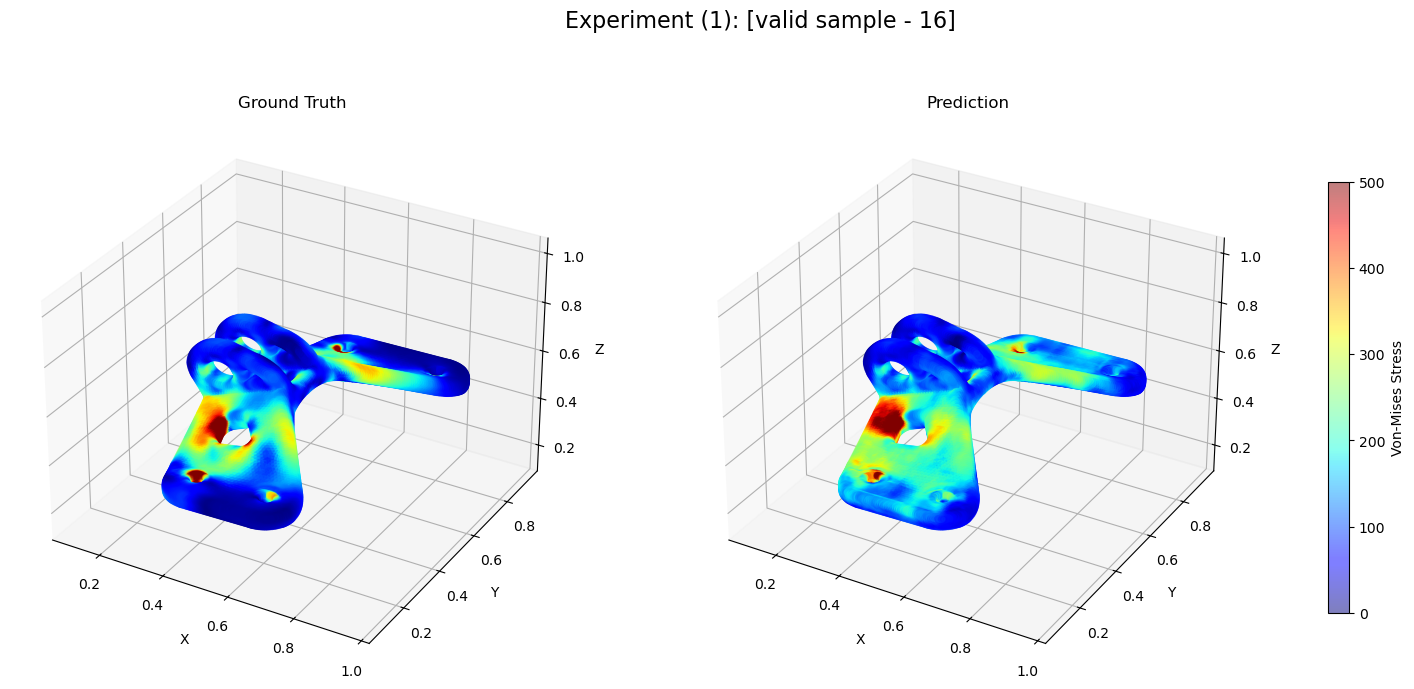

In [4]:
vmin = 0
vmax = 500
cmap = 'jet'

valid_sample_id_smallver = [20, 4, 0, 12, 16]

trainer.model.eval()

with torch.no_grad():
    for index, graph in enumerate(trainer.valid_loader):

        graph = graph.to(trainer.device)
        pred = trainer.model(graph)
        y = graph.y
        coords = graph.x[:, :3] # 좌표값 추출

        pred = pred * (trainer.target_std) + trainer.target_mean
        y = y * (trainer.target_std) + trainer.target_mean
        #coords = coords * (trainer.coords_max - trainer.coords_min) + trainer.coords_min

        pred_numpy = pred.to("cpu").detach().numpy()
        y_numpy = y.to("cpu").detach().numpy()
        coords_numpy = coords.to("cpu").detach().numpy()

        print(pred_numpy.shape)
        print(y_numpy.shape)

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_numpy[:, 0].min(), coords_numpy[:, 0].max()
        y_min, y_max = coords_numpy[:, 1].min(), coords_numpy[:, 1].max()
        z_min, z_max = coords_numpy[:, 2].min(), coords_numpy[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # 3D 그래프 준비
        fig = plt.figure(figsize=(20, 8))

        # y (Ground Truth) 그래프
        ax_gt = fig.add_subplot(1, 2, 1, projection='3d')
        sc_gt = ax_gt.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=y_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_gt.set_title(f'Ground Truth')

        # 동일한 비율로 축 설정
        ax_gt.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_gt.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_gt.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_gt.set_xlabel('X')
        ax_gt.set_ylabel('Y')
        ax_gt.set_zlabel('Z')

        # pred (Prediction) 그래프
        ax_pred = fig.add_subplot(1, 2, 2, projection='3d')
        sc_pred = ax_pred.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=pred_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction')

        # 동일한 비율로 축 설정
        ax_pred.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_pred.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_pred.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_zlabel('Z')

        plt.suptitle(f'Experiment (1): [valid sample - {valid_sample_id_smallver[index]}]', fontsize=16)
        cbar = fig.colorbar(sc_gt, ax=fig.get_axes(), location='right', shrink=0.7, aspect=20, label='Von-Mises Stress')

        plt.show()

(36544, 1)
(36544, 1)


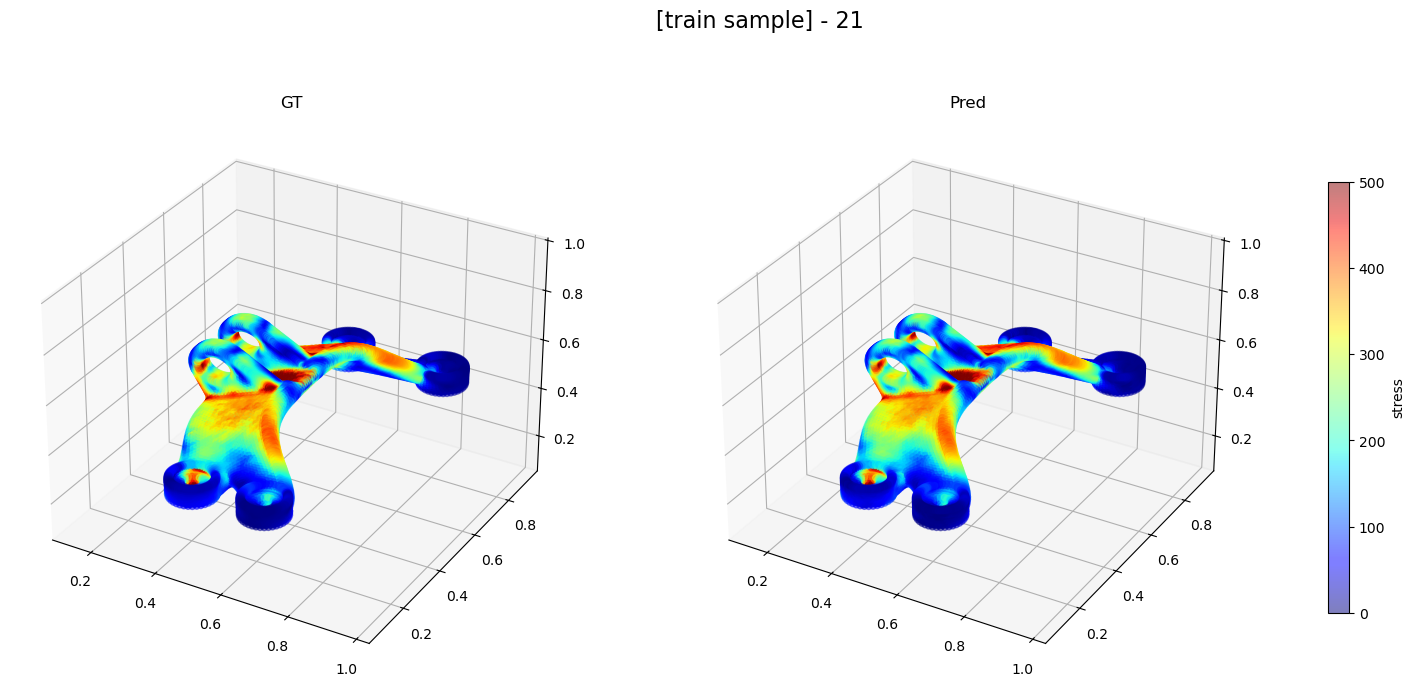

(21906, 1)
(21906, 1)


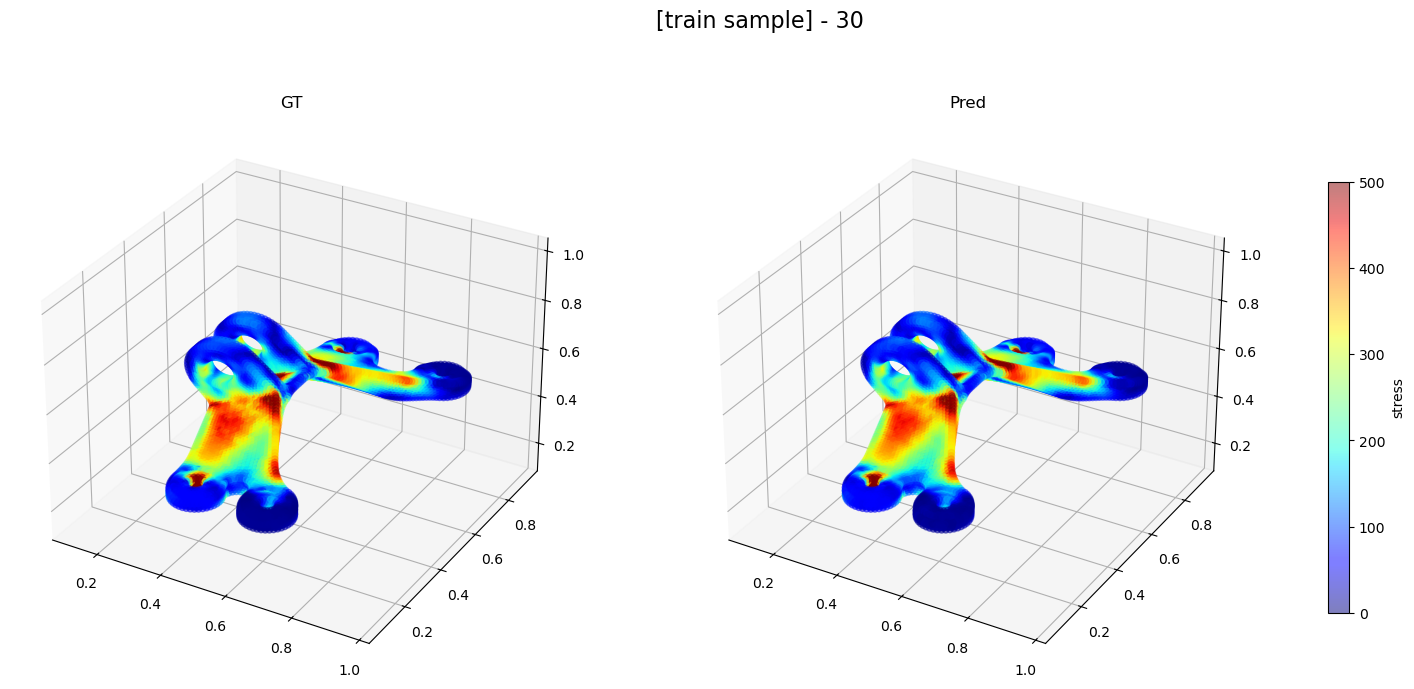

(58270, 1)
(58270, 1)


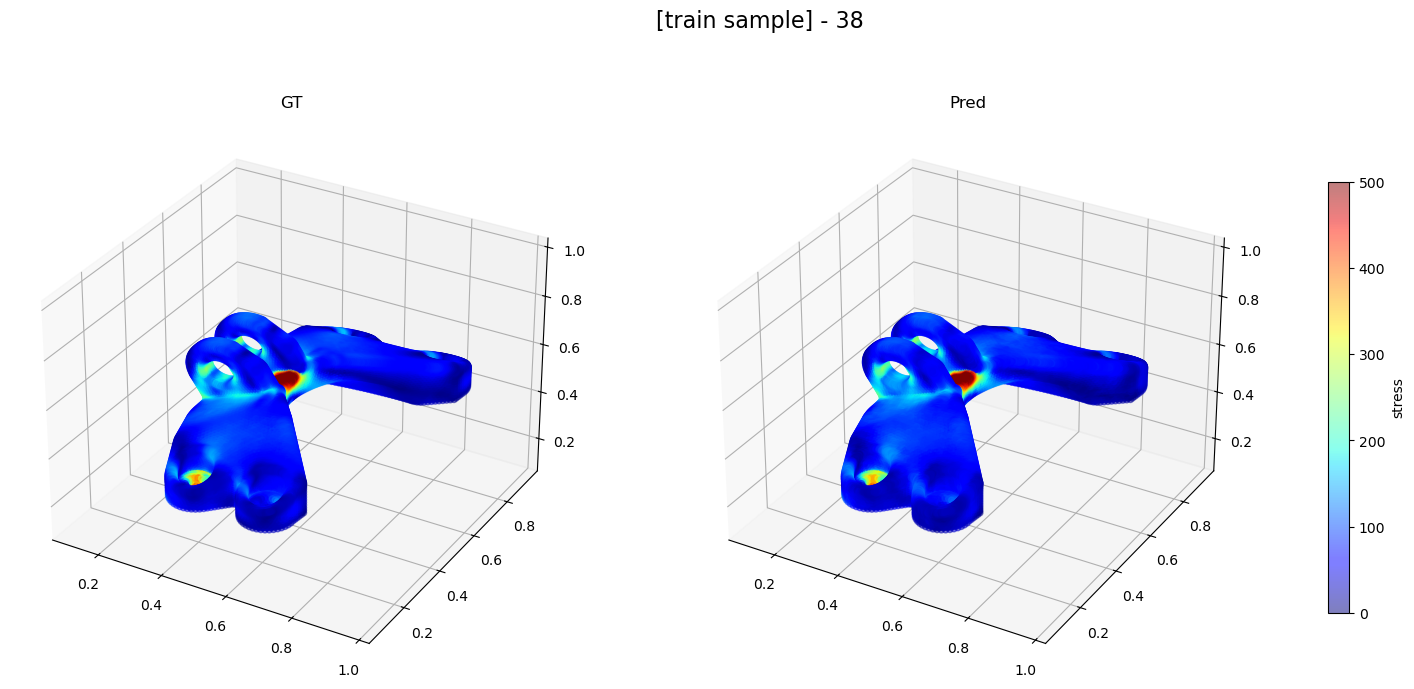

(28832, 1)
(28832, 1)


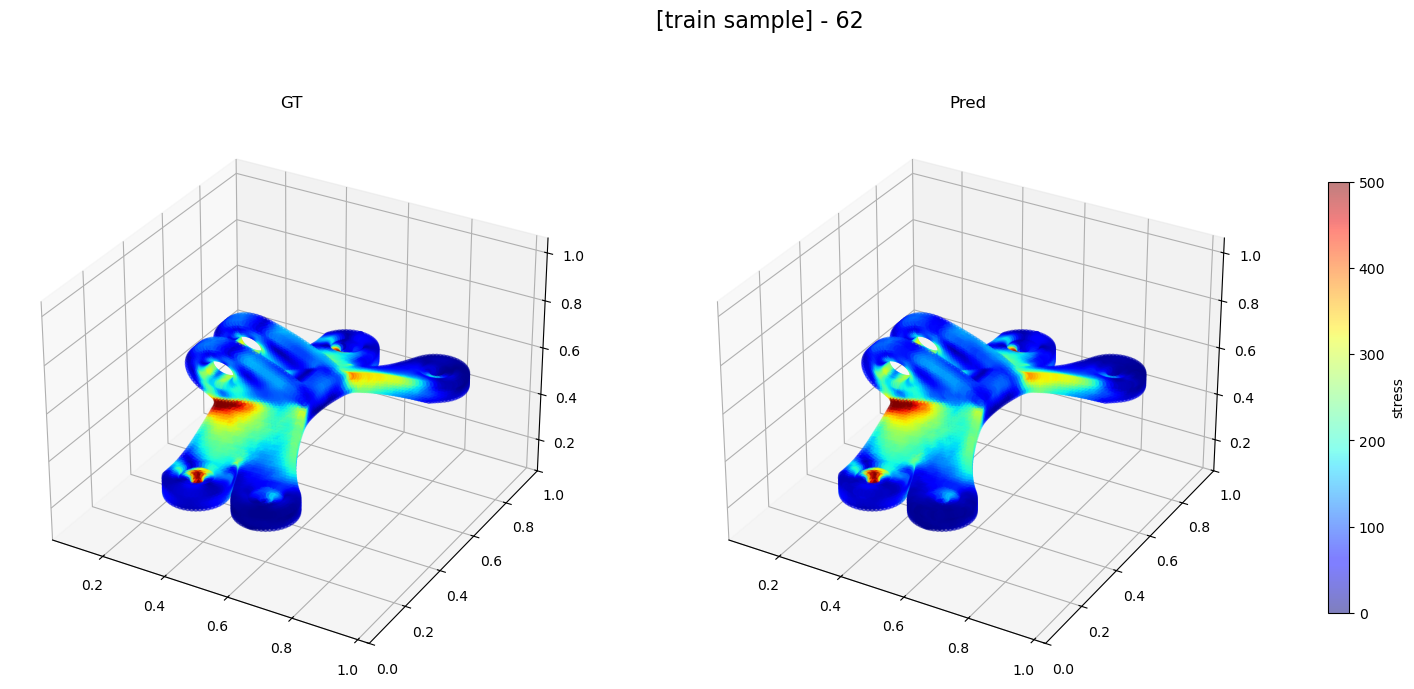

In [5]:
vmin = 0
vmax = 500
cmap = 'jet'

train_sample_id_smallver = [21, 30, 38, 62]

trainer.model.eval()

with torch.no_grad():
    for index, graph in enumerate(trainer.train_loader):

        graph = graph.to(trainer.device)
        pred = trainer.model(graph)
        y = graph.y
        coords = graph.x[:, :3] # 좌표값 추출

        pred = pred * (trainer.target_std) + trainer.target_mean
        y = y * (trainer.target_std) + trainer.target_mean
        #coords = coords * (trainer.coords_max - trainer.coords_min) + trainer.coords_min

        pred_numpy = pred.to("cpu").detach().numpy()
        y_numpy = y.to("cpu").detach().numpy()
        coords_numpy = coords.to("cpu").detach().numpy()

        print(pred_numpy.shape)
        print(y_numpy.shape)

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_numpy[:, 0].min(), coords_numpy[:, 0].max()
        y_min, y_max = coords_numpy[:, 1].min(), coords_numpy[:, 1].max()
        z_min, z_max = coords_numpy[:, 2].min(), coords_numpy[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # 3D 그래프 준비
        fig = plt.figure(figsize=(20, 8))

        # y (Ground Truth) 그래프
        ax_gt = fig.add_subplot(1, 2, 1, projection='3d')
        sc_gt = ax_gt.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=y_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_gt.set_title(f'GT')

        # 동일한 비율로 축 설정
        ax_gt.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_gt.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_gt.set_zlim([mid_z - max_range, mid_z + max_range])

        # pred (Prediction) 그래프
        ax_pred = fig.add_subplot(1, 2, 2, projection='3d')
        sc_pred = ax_pred.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=pred_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Pred')

        # 동일한 비율로 축 설정
        ax_pred.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_pred.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_pred.set_zlim([mid_z - max_range, mid_z + max_range])

        plt.suptitle(f'[train sample] - {train_sample_id_smallver[index]}', fontsize=16)
        cbar = fig.colorbar(sc_gt, ax=fig.get_axes(), location='right', shrink=0.7, aspect=20, label='stress')

        plt.show()